In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim, flatten
from torch.nn import Linear, Conv2d, MaxPool2d, BatchNorm2d, Module, Dropout, ReLU
import torch.nn.functional as F
import random
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                               ])

trainset = datasets.MNIST('./', download=True, train=True,  transform=transform)
testset = datasets.MNIST('./', download=True, train=False, transform=transform)
#print(trainset.targets)
random.shuffle(trainset.targets)
#print(trainset.targets)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
print(len(trainloader))

938


In [4]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28*28,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,64)
        self.fc4 = nn.Linear(64,10)
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        #x = F.log_softmax(self.fc3(x), dim=1)       
        return x


# Shuffle Labels before training

In [ ]:
model = DNN()
model.to(device)
optimize = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.NLLLoss()
step = 0
epoch = 1000
trainloss = []
testloss = []
trainacc = []
testacc = []
for e in range(epoch):
    train_loss = 0
    train_acc = 0
    model.train()
    for images, labels in trainloader:
        step+=1
        images, labels = images.to(device), labels.to(device)
        optimize.zero_grad()
        logps = model(images) #forward propagation
        loss = loss_fn(logps, labels) #calculate loss
        train_loss+=loss.item()
        
        _, pred = logps.max(1)
        train_acc += (pred == labels).sum()
        
        loss.backward() #backward propagation
        optimize.step() #update weights
    
    tloss = train_loss/len(trainloader)
    trainloss.append(tloss)
    tacc = train_acc/len(trainset)
    trainacc.append(tacc)
    
    with torch.no_grad():
        valloss = 0
        acc = 0
        model.eval()
        for img, label in testloader:
            img, label = img.to(device), label.to(device)
            logps = model(img) #forward propagation
            loss = loss_fn(logps, label) #calculate loss
            valloss+=loss.item()
            _, pred = logps.max(1)
            acc += (pred == label).sum()
        vloss = valloss/len(testloader)
        testloss.append(vloss)
        accr = acc/len(testset)
        testacc.append(accr)
        
        if e%10==0:
            print("Epoch: {}  Train Loss: {:.4f}  Val Loss: {:.4f}  Val_Acc: {:.2}".format(e, tloss, vloss, accr))

Epoch: 0  Train Loss: 2.3021  Val Loss: 2.3029  Val_Acc: 0.11
Epoch: 10  Train Loss: 2.2931  Val Loss: 2.3112  Val_Acc: 0.11
Epoch: 20  Train Loss: 2.2255  Val Loss: 2.3645  Val_Acc: 0.13
Epoch: 30  Train Loss: 2.0494  Val Loss: 2.4944  Val_Acc: 0.13
Epoch: 40  Train Loss: 1.7884  Val Loss: 2.7772  Val_Acc: 0.1
Epoch: 50  Train Loss: 1.4946  Val Loss: 3.2750  Val_Acc: 0.11
Epoch: 60  Train Loss: 1.2036  Val Loss: 3.7009  Val_Acc: 0.11
Epoch: 70  Train Loss: 0.9396  Val Loss: 4.2939  Val_Acc: 0.12
Epoch: 80  Train Loss: 0.7252  Val Loss: 5.2064  Val_Acc: 0.12
Epoch: 90  Train Loss: 0.5681  Val Loss: 6.4721  Val_Acc: 0.096
Epoch: 100  Train Loss: 0.4457  Val Loss: 7.1098  Val_Acc: 0.1
Epoch: 110  Train Loss: 0.3926  Val Loss: 8.3435  Val_Acc: 0.1
Epoch: 120  Train Loss: 0.3327  Val Loss: 8.7266  Val_Acc: 0.11
Epoch: 130  Train Loss: 0.3069  Val Loss: 9.9605  Val_Acc: 0.096
Epoch: 140  Train Loss: 0.3006  Val Loss: 10.3396  Val_Acc: 0.11
Epoch: 150  Train Loss: 0.2552  Val Loss: 10.7959  

# Load and Save Model

In [ ]:
#Save the checkpoint 
checkpoint = {'state_dict': model.state_dict(),
             'Tloss': trainloss,
             'Vloss': testloss,
             'Tacc': trainacc,
             'Vacc': testacc,
             'epoch': epoch}
torch.save(checkpoint, "hw13random.pth")

In [5]:
#Function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    model = DNN()
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict = checkpoint['state_dict']
    trainloss = checkpoint['Tloss']
    trainacc = checkpoint['Tacc']
    valloss = checkpoint['Vloss']
    valacc = checkpoint['Vacc']
    epoch = checkpoint['epoch']
    
    return model, trainloss, trainacc, valloss, valacc, epoch

model, tl, ta, vl, va, e = load_checkpoint('hw13random.pth')  

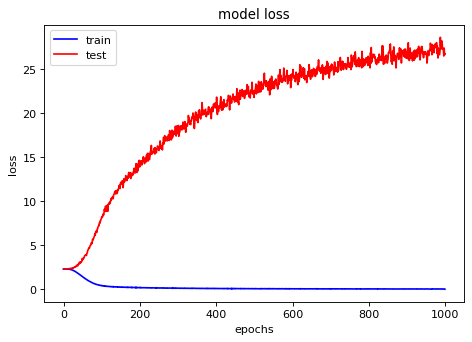

In [6]:
#Plot of model loss
fig = plt.figure(figsize=(6, 8), dpi=80)
plt.subplot(2,1,2)
#plt.plot(np.arange(0,epoch), cnnloss, "b")
plt.plot(np.arange(0,e), tl, "b")
plt.plot(np.arange(0,e), vl, "r")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test', 'model2'])
plt.tight_layout()
plt.savefig('Random_loss.png')

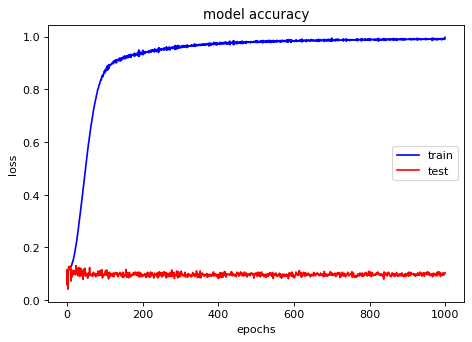

In [7]:
#Plot of model accuracy
fig = plt.figure(figsize=(6, 8), dpi=80)
plt.subplot(2,1,2)
#plt.plot(np.arange(0,epoch), cnnloss, "b")
plt.plot(np.arange(0,e), ta, "b")
plt.plot(np.arange(0,e), va, "r")
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test', 'model2'])
plt.tight_layout()
plt.savefig('Random_accuracy.png')